# *EmotioNet* - Recognizing Emotion in Music with PyTorch

This document contains the full implementation of the project.
The code herein was fully written by Jonas, Chielo, Ausef, and Jennifer.

It contains:
1.   Raw Data Signal Processing
2.   Machine Learning Model
3.   Hyperparameter Tuning
4.   Baseline Model
5.   Performance Analysis

In [ ]:
# Grants access to Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


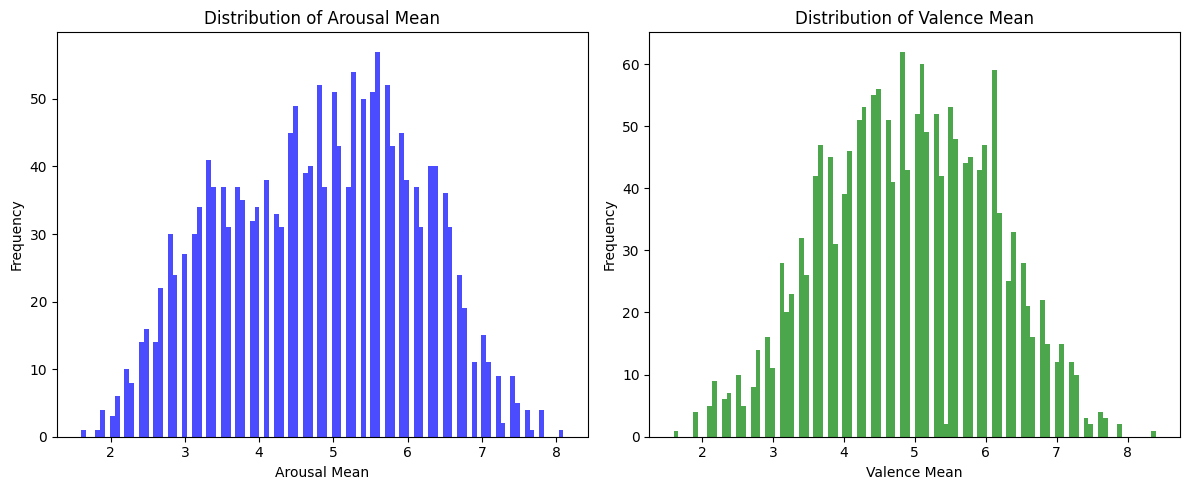

                                            File Name  valence_mean  \
0   03-Meydan-Tired-of-life(chosic.com)-[AudioTrim...      0.216667   
1   arthur-vyncke-cherry-metal(chosic.com)-[AudioT...      0.400000   
2        Bird-Bath(chosic.com)-[AudioTrimmer.com].mp3      0.725000   
3         Black-Vortex(chosic.com)-[AudioTrimmer.com]      0.325000   
4                  closer-9353-[AudioTrimmer.com].mp3      0.400000   
..                                                ...           ...   
71            xLost-and-Found(chosic (mp3cut.net).mp3      0.700000   
72  xMorning-Routine-Lofi-Study-Music(chosic (mp3c...      0.725000   
73               xSerendipity(chosic (mp3cut.net).mp3      0.725000   
74                xSmall-Town(chosic (mp3cut.net).mp3      0.800000   
75      xSunset-Landscape(chosic (mp3cut.net) (1).mp3      0.800000   

    arousal_mean  
0       0.166667  
1       0.750000  
2       0.150000  
3       0.475000  
4       0.350000  
..           ...  
71      0.3000

In [ ]:
# Imports necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from operator import truth
from sklearn import metrics
import seaborn as sns
import librosa
import librosa.display

# file paths for each team member
Jennifer = "/content/drive/MyDrive/APS360"
Chielo = "/content/drive/MyDrive/Colab Notebooks/APS360"
Jonas = "/content/drive/MyDrive/Colab Notebooks/APS360"
Ausef = "/content/drive/MyDrive/YEAR 3 SEM 1/APS360"
file_path = Jonas

# Extracts annotations_df, these are the truth labels for our audio samples
df = pd.read_csv(f'{file_path}/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
df.columns = df.columns.str.strip()
initial_df = df.dropna()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(initial_df['arousal_mean'], bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Arousal Mean')
plt.xlabel('Arousal Mean')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(initial_df['valence_mean'], bins=100, color='green', alpha=0.7)
plt.title('Distribution of Valence Mean')
plt.xlabel('Valence Mean')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

#print(initial_df['valence_mean'].mean())

##################### Extracts annotations for the new data samples from independent source
new_data_df = pd.read_csv(f'{file_path}/Ranking Music Sentiment.csv')
new_data_df.columns = new_data_df.columns.str.strip() # Sanitises column names
new_data_df = new_data_df.dropna()

## 1. Raw Data Processing
This section is devoted to extracting spectrogram features from raw music data files using the **Librosa Python Library**. We extract the following features:
1. MFCCs
2. Spectral Contrast
3. Chroma
4. Tempogram

We subsequently define a class that integrates with PyTorch DataLoader, to handle the creation of Batches, while also formatting the datasets so they are padded, normalised, tensorised and are attached to their truth labels.



In [ ]:
def process_and_sample_data(df, valence_col='valence_mean', arousal_col='arousal_mean', rows_per_emotion=223, random_state=42):

    def categorize_emotion(df, valence_col, arousal_col, val_thresh=4.5, ar_thresh=4.5):
        # from sklearn.preprocessing import MinMaxScaler
        # scaler = MinMaxScaler()
        # df[[valence_col, arousal_col]] = scaler.fit_transform(df[['valence_mean', 'arousal_mean']])

        def determine_emotion(row):
            if row[valence_col] >= val_thresh and row[arousal_col] > ar_thresh:
                return 'Happy'
            elif row[valence_col] <= val_thresh and row[arousal_col] < ar_thresh:
                return 'Sad'
            elif row[valence_col] > val_thresh and row[arousal_col] <= ar_thresh:
                return 'Aggressive'
            elif row[valence_col] < val_thresh and row[arousal_col] >= ar_thresh:
                return 'Calm'
            else:
                return 'Neutral'

        df['Emotion'] = df.apply(determine_emotion, axis=1)
        return df

    df = categorize_emotion(df, valence_col, arousal_col)

    grouped = df.groupby('Emotion')
    extracted_data = pd.DataFrame()
    scrapped_data = pd.DataFrame()

    for emotion, group_df in grouped:
        print(emotion)
        sampled_rows = group_df.sample(n=min(len(group_df), rows_per_emotion), random_state=random_state)
        extracted_data = pd.concat([extracted_data, sampled_rows])
        unsampled_rows = group_df.drop(sampled_rows.index)
        scrapped_data = pd.concat([scrapped_data, unsampled_rows])


    # Shuffling
    final_df = extracted_data.sample(frac=1, random_state=random_state).reset_index(drop=True)
    scrapped_df = scrapped_data.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return final_df, scrapped_df

In [ ]:
#df.shape
df, scrapped_df = process_and_sample_data(initial_df)
print(df)
print(df['arousal_mean'].mean())
print(scrapped_df['Emotion'].value_counts())

Aggressive
Calm
Happy
Neutral
Sad
     song_id  valence_mean  valence_std  arousal_mean  arousal_std     Emotion
0       1903           3.2         2.36           6.9         1.76        Calm
1       1434           3.7         1.68           2.8         1.17         Sad
2       1107           3.0         1.26           3.2         1.33         Sad
3        244           4.3         1.35           4.2         1.66         Sad
4       1116           5.7         1.90           3.0         1.41  Aggressive
..       ...           ...          ...           ...          ...         ...
871     1036           4.8         1.60           3.0         0.89  Aggressive
872      162           3.7         1.68           4.6         1.02        Calm
873     1643           4.4         1.56           4.3         1.79         Sad
874     1501           5.0         1.95           4.9         1.97       Happy
875     1014           4.9         1.04           4.5         1.28  Aggressive

[876 rows x 6 col

In [ ]:
# these values were pre-processed
MFCC_MIN, MFCC_MAX =  -756.3789672851562, 308.3226318359375
SPEC_CONTRAST_MIN, SPEC_CONTRAST_MAX = 0.024821940717373536, 80.62911344477574
CHROMA_MIN, CHROMA_MAX = 0.0, 1.0

#################### HELPER FUNCTION 1: Librosa Feature Extraction ###########################################################
def extract_features(index, new_data = False):
  # Parameter: path to .mp3 file
  # Returns list with features.
  song_id = get_song_id(index, new_data)
  
  if new_data:
    path = f'{file_path}/new samples cropped/{song_id}'
  else:
    path = f'{file_path}/DEAM_audio/MEMD_audio/{song_id}.mp3'

  try:
    y, sr = librosa.load(path, sr=44100)
  except:
    y, sr = librosa.load(f'{path}.mp3', sr=44100)

  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512, fmin=200, n_bands=7)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512, n_chroma=12)
  all_features = [mfccs, spectral_contrast, chroma]

  all_features = [feature[:, :3800] for feature in all_features] # Curtailed dataset
  tensor_features = [torch.tensor(feature, dtype=torch.float32) for feature in all_features] # Tensorization

  # Normalisation and Padding of tensors
  normalized_mfccs = normalize_feature(tensor_features[0], MFCC_MIN, MFCC_MAX)
  normalized_spectral_contrast = normalize_feature(tensor_features[1], SPEC_CONTRAST_MIN, SPEC_CONTRAST_MAX)
  normalized_spectral_contrast = F.pad(normalized_spectral_contrast, (0, 0, 2, 3))
  normalized_chroma = normalize_feature(tensor_features[2], CHROMA_MIN, CHROMA_MAX)
  normalized_chroma = F.pad(normalized_chroma, (0, 0, 0, 1))

  # Feature Stacking
  normalized_stacked_features = torch.stack([normalized_mfccs, normalized_spectral_contrast, normalized_chroma], dim=0)
  return normalized_stacked_features #,all_features (for vizualisation)


########### HELPER FUNCTION 2: Generates randomized unique indices for training, validation, and testing samples. ##########
def get_indices(total_samples, num_training, num_validation, num_test):
    torch.manual_seed(1000)
    permuted_indices = torch.randperm(total_samples)
    training_indices = permuted_indices[:num_training]
    validation_indices = permuted_indices[num_training:num_training+num_validation]
    test_indices = permuted_indices[num_training+num_validation:]
    # print(training_indices[0:10], validation_indices[0:10], test_indices[0:10])
    # print(total_samples, num_training, num_validation, num_test)
    return training_indices, validation_indices, test_indices


#################### HELPER FUNCTION 3: Receives index and returns song ID. ################################################
def get_song_id(index, new_data):
    if torch.is_tensor(index):
      index = index.item()
    if new_data:
      song_id = new_data_df.loc[index, 'File Name']
    else:
      song_id = df.loc[index, 'song_id']
    return song_id


#################### HELPER FUNCTION 4: Receives index and returns the truth label of song, tensorized. ####################
def get_truth_label(index, new_data):
    if torch.is_tensor(index):
      index = index.item()
    if new_data:
      valence = new_data_df.loc[index, 'valence_mean']
      arousal = new_data_df.loc[index, 'arousal_mean']
    else:
      valence = df.loc[index, 'valence_mean']
      arousal = df.loc[index, 'arousal_mean']

    if not new_data:
      normalized_valence = normalize_label(valence)
      normalized_arousal = normalize_label(arousal)
      return torch.tensor([normalized_valence, normalized_arousal], dtype=torch.float32)

    return torch.tensor([valence, arousal], dtype=torch.float32)

#################### HELPER FUNCTION 5: Normalises arousal and valence values ###############################################
def normalize_label(value):
    return ((value - 1.0) / (9.0 - 1.0))


#################### HELPER FUNCTION 6: Normalises features #################################################################
def normalize_feature(feature, feature_min, feature_max):
    # Normalize feature with pre-computed min and max values
    return (feature - feature_min) / (feature_max - feature_min)


#################### HELPER FUNCTION 7: Produces Data Loader for PyTorch Model ##############################################
def get_data_loader(batch_size):
  training_indices, validation_indices, test_indices = get_indices(len(df), int(len(df)*0.7), int(len(df)*0.15), len(df) - int(len(df)*0.85) - int(len(df)*0.15))

  train_dataset = MusicEmotionDataset(training_indices)
  val_dataset = MusicEmotionDataset(validation_indices)
  test_dataset = MusicEmotionDataset(test_indices)

  print(len(training_indices))
  print(len(validation_indices))
  print(len(test_indices))

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  return train_loader, val_loader, test_loader

In [ ]:
# This class formats the dataset to be processed by the PyTorch DataLoader

class MusicEmotionDataset(Dataset):
    def __init__(self, indices, new_data = False):
        self.indices = indices
        self.new_data = new_data

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
      try:
          feature_stack = extract_features(self.indices[idx], self.new_data)
          labels = get_truth_label(self.indices[idx], self.new_data)
      except KeyError as e:
          print(f"KeyError for index {idx}: {e}")
          feature_stack, labels = None, None

      return feature_stack, labels

### The rest of this Data-Processing section is devoted to small simulations, tests, and vizualisations of the components implemented above.  

In [ ]:
# Feature Visualiser, to use this, ajust return return stacked_features to return (stacked_features, all_features) in extract_features function
channel = 1
index = 0

_,spectrograms = extract_features(index)
print(spectrograms[channel].shape)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrograms[channel], x_axis='time', sr=44100)
plt.colorbar()
if channel == 0:
  title = 'MFCC'
if channel == 1:
  title = 'Spectral Contrast'
if channel == 2:
  title = 'Chroma'
plt.title(title)
plt.tight_layout()
plt.show()

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(batch_size=16)

# for i, (inputs, labels) in enumerate(train_loader):
#     print(f"Batch {i}: Inputs shape {inputs[i].shape}, Labels shape {labels.shape}")
#     if i == 0:  # Just check the first batch
#         # If images, you can plot using matplotlib or similar
#         # If text or other data, you can print the raw data or statistics
#         break

613
131
132


In [ ]:
i = [0]
s = MusicEmotionDataset(i)
item = s.__getitem__(0)

1903


In [ ]:
item[0].shape

torch.Size([3, 13, 3800])

In [ ]:
# Simulation of our Machine Learning Model to understand input sizes and structure (only for analysis purposes)

from torch.autograd import Variable
import torch.nn as nn

# Initialize a mock input tensor
# Assuming the input dimensions are [Batch, Channels=3, Height=13, Width=3870]
mock_input = Variable(torch.rand(32, 3, 13, 3870))

# Pass the mock input through the conv and pool layers as defined in your EmotioNet
conv1 = nn.Conv2d(3, 32, kernel_size=(13, 5), stride=(1, 2))
pool1 = nn.MaxPool2d((1, 2))
conv2 = nn.Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
pool2 = nn.MaxPool2d((1, 2))

# Forward pass through the network layers
out = conv1(mock_input)
out = pool1(out)
out = conv2(out)
out = pool2(out)

# Print out the shape of the tensor before flattening
print(out.size())  # This will give you the size you should use in your view() method


torch.Size([32, 64, 1, 482])


# 2. Machine Learning Model
### This section contains the implementation of the Emotion Recognition Model for this project. It contains all functions that describe how the model is trained and evaluated.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class EmotioNet(nn.Module):
    def __init__(self, name):
        super(EmotioNet, self).__init__()
        self.name = name
        self.outputs_t = []
        self.labels_t = []
        self.outputs_v = []
        self.labels_v = []

        self.conv1 = nn.Conv2d(3, 32, kernel_size=(13, 5), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((1, 2))

        self.conv2 = nn.Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((1, 2))

        self.fc1_input_features = 64 * 1 * 237
        self.fc1 = nn.Linear(self.fc1_input_features, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model Training section is contained below.

In [ ]:
import tensorflow as tf
import os
use_cuda = True

In [ ]:
def train_net(net, train_loader, val_loader, batch_size=32, learning_rate=0.03, num_epochs=3):
    torch.manual_seed(1000)


    if use_cuda and torch.cuda.is_available():
        net.cuda()
        print('Model Using Cuda')
    else:
        print('Model not using Cuda')

    net.outputs_v = []
    net.labels_v = []

    criterion = nn.MSELoss()
    #optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e^-4)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay = 1e-3)# this was the optimizer used up
    #to and including emotio_model_ext, changed from there onwards to ADAM
    #update went back to SGD, ADAM sucked

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    train_mae = np.zeros(num_epochs)
    val_mae = np.zeros(num_epochs)

    start_time = time.time()
    #i = -1 #num epochs
    for epoch in range(num_epochs):
        #i += 1

        total_train_loss = 0.0
        total_val_loss = 0.0
        total_train_mae = 0.0
        total_val_mae = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            try:
                inputs, labels = data
                #############################################
                # To Enable GPU Usage
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.to('cuda')
                  labels = labels.to('cuda')
                #############################################
                print(f"Batch {i}: Inputs shape {inputs[i].shape}, Labels shape {labels.shape}")
          # Rest of the code...
            except Exception as e:
                print(f"Error encountered in batch {i}: {e}")
                break

            labels = labels.float()

            optimizer.zero_grad()

            outputs = net(inputs)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()


            net.outputs_t.append(outputs.detach()) #append to save outputs for outside training usage
            net.labels_t.append(labels)

            total_train_loss += loss.item()
            total_train_mae += torch.mean(torch.abs(outputs - labels)).item()
            total_epoch += len(labels)


        train_loss[epoch] = float(total_train_loss) / (i + 1)
        train_mae[epoch] = float(total_train_mae) / (i + 1)

        val_loss[epoch], val_mae[epoch] = evaluate(net, val_loader, criterion)

        print(f"Epoch {epoch+1}: Train loss: {train_loss[epoch]:.4f}, Train MAE: {train_mae[epoch]:.4f} | "
              f"Validation loss: {val_loss[epoch]:.4f}, Validation MAE: {val_mae[epoch]:.4f}")

        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Total time elapsed: {elapsed_time:.2f} seconds")


    file_path = os.path.join('/content/drive/MyDrive/YEAR 3 SEM 1/APS360/MODELS/', net.name)
    torch.save(net, file_path)
    print("Model saved in google drive as", net.name)

    ###############Plotting Predictions################
    #Create a figure and axes object.
    fig, ax = plt.subplots()
    # Set x-axis range
    plt.xlim((0,1))
    # Set y-axis range
    plt.ylim((0,1))

    plt.xlabel("Valence Score")
    plt.ylabel("Arousal Score")
    plt.title("Model Predictions")

    plt.plot([0.45,0.45],[0,1], linewidth=3, color='black' )
    plt.plot([0,1],[0.45,0.45], linewidth=3, color='black' )
    plt.plot([0.225,0.225],[0,0.45], linewidth=1, color='black' )
    plt.plot([0.225,0.225],[0.45,1], linewidth=1, color='black' )
    plt.plot([0,0.45],[0.225,0.225], linewidth=1, color='black' )
    plt.plot([0,0.45],[0.7,0.7], linewidth=1, color='black' )
    plt.plot([0.225,0.225],[0.45,1], linewidth=1, color='black' )
    plt.plot([0.72,0.72],[0.45,1], linewidth=1, color='black' )
    plt.plot([0.45,1],[0.7,0.7], linewidth=1, color='black' )
    plt.plot([0.72,0.72],[0,0.45], linewidth=1, color='black' )
    plt.plot([0.45,1],[0.225,0.225], linewidth=1, color='black' )

    # Iterate over the list of tensors and plot each tensor as a scatter plot.
    for tensor in net.outputs_t:
      tensor = tensor.cpu() #convert back from .cuda
      ax.scatter(tensor[:, 0], tensor[:, 1])

    ###################################################

    # Saving results to CSV for later analysis
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt(f"{model_path}_train_loss.csv", train_loss)
    np.savetxt(f"{model_path}_train_mae.csv", train_mae)
    np.savetxt(f"{model_path}_val_loss.csv", val_loss)
    np.savetxt(f"{model_path}_val_mae.csv", val_mae)
    net = net.cpu()

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_mae = 0.0
    total_epoch = 0

    for i, data in enumerate(loader, 0):
        inputs, labels = data


        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          inputs = inputs.to('cuda')
          labels = labels.to('cuda')
        #############################################
        labels = labels.float()

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Save outputs for plotting
        net.outputs_v.append(outputs.detach())
        net.labels_v.append(labels)

        total_loss += loss.item()
        total_mae += torch.mean(torch.abs(outputs - labels)).item()
        total_epoch += len(labels)

    return float(total_loss) / (i + 1), float(total_mae) / (i + 1)

###############################################################################
# Training Curve
def plot_training_curve(path):

    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_mae.csv".format(path))
    val_err = np.loadtxt("{}_val_mae.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def create_mood_dataframe(net):
    # Convert the outputs and labels to flattened lists
    outputs_flat = [item.cpu().tolist() for sublist in net.outputs_t for item in sublist]
    labels_flat = [item.cpu().tolist() for sublist in net.labels_t for item in sublist]

    # Prepare data for DataFrame
    data = []
    for output, label in zip(outputs_flat, labels_flat):
        mood_pred, sub_mood_pred = categorize_mood(*output)
        mood_truth, sub_mood_truth = categorize_mood(*label)

        data.append([
            *output, mood_pred, sub_mood_pred,
            *label, mood_truth, sub_mood_truth
        ])

    # Create DataFrame
    df = pd.DataFrame(data, columns=[
        'Arousal_Pred', 'Valence_Pred', 'Mood_Pred', 'Sub_Mood_Pred',
        'Arousal_Truth', 'Valence_Truth', 'Mood_Truth', 'Sub_Mood_Truth'
    ])

    return df

def categorize_mood(valence, arousal):

    mood_matrix = {
        # High Valence, High Arousal
        (1, 1): [
            ('Happy', 'Ecstasy'),        # Extremely high valence and arousal
            ('Happy', 'Euphoria'),       # High valence, moderately high arousal
            ('Happy', 'Cheerfulness'),   # Moderately high valence, high arousal
            ('Happy', 'Enthusiasm')      # Moderately high valence and arousal
        ],
        # Low Valence, High Arousal
        (0, 1): [
            ('Aggressive', 'Terror'),    # Extremely low valence and high arousal
            ('Aggressive', 'Panic'),     # Low valence, moderately high arousal
            ('Aggressive', 'Rage'),      # Moderately low valence, high arousal
            ('Aggressive', 'Frustration') # Moderately low valence and arousal
        ],
        # High Valence, Low Arousal
        (1, 0): [
            ('Calm', 'Bliss'),           # Extremely high valence and low arousal
            ('Calm', 'Relaxation'),      # High valence, moderately low arousal
            ('Calm', 'Contentment'),     # Moderately high valence, low arousal
            ('Calm', 'Serenity')         # Moderately high valence and arousal
        ],
        # Low Valence, Low Arousal
        (0, 0): [
            ('Sad', 'Depression'),       # Extremely low valence and arousal
            ('Sad', 'Gloom'),            # Low valence, moderately low arousal
            ('Sad', 'Despair'),          # Moderately low valence, low arousal
            ('Sad', 'Melancholy')        # Moderately low valence and arousal
        ]
    }

    # Determine the category based on valence and arousal thresholds
    valence_category = 1 if valence > 0.5 else 0
    arousal_category = 1 if arousal > 0.5 else 0

    # Further sub-categorization within each quadrant
    quadrant = mood_matrix[(valence_category, arousal_category)]
    index = 0
    if valence_category == 1 and arousal_category == 1:
        index = 0 if valence > 0.75 and arousal > 0.75 else \
                1 if valence > 0.75 else \
                2 if arousal > 0.75 else \
                3
    elif valence_category == 0 and arousal_category == 1:
        index = 0 if valence <= 0.25 and arousal > 0.75 else \
                1 if valence <= 0.25 else \
                2 if arousal > 0.75 else \
                3
    elif valence_category == 1 and arousal_category == 0:
        index = 0 if valence > 0.75 and arousal <= 0.25 else \
                1 if valence > 0.75 else \
                2 if arousal <= 0.25 else \
                3
    else:  # valence_category == 0 and arousal_category == 0
        index = 0 if valence <= 0.25 and arousal <= 0.25 else \
                1 if valence <= 0.25 else \
                2 if arousal <= 0.25 else \
                3

    mood, sub_mood = quadrant[index]

    return mood, sub_mood



Below is a function that takes in any network that has been trained, and plots a few predictions it made and a dashed line to its corresponding ground truth label, this is a good visualization tool to understand our models performance. User can specify how many points they want to display, or if they want to go over validation or training data.

In [ ]:
import random
import matplotlib.patches as mpatches

#FUNCTION TO PLOT PREDICTIONS VS TRUTH POINTS
def plot_pred_vs_truth(net, t = True,  num_points = 5):
  if t:
    outputs_plot_c = net.outputs_t
    labels_plot_c = net.labels_t
  else:
    outputs_plot_c = net.outputs_v
    labels_plot_c = net.labels_v

  outputs_plot = []
  for i in outputs_plot_c:
    outputs_plot.append(i.cpu())

  labels_plot = []
  for i in labels_plot_c:
    labels_plot.append(i.cpu())


  outputs_list = []
  for tensor in outputs_plot:
    for i in range(len(tensor)):
      outputs_list.append(tensor[i].tolist())

  labels_list = []
  for tensor in labels_plot:
    for i in range(len(tensor)):
      labels_list.append(tensor[i].tolist())

  print(len(outputs_list))


# Create a figure and axes object.
  fig, ax = plt.subplots()
  # Set x-axis range
  plt.xlim((0,1))
    # Set y-axis range
  plt.ylim((0,1))

  plt.xlabel("Valence Score")
  plt.ylabel("Arousal Score")


  plt.plot([0.45,0.45],[0,1], linewidth=3, color='black' )
  plt.plot([0,1],[0.45,0.45], linewidth=3, color='black' )
  plt.plot([0.225,0.225],[0,0.45], linewidth=1, color='black' )
  plt.plot([0,0.45],[0.225,0.225], linewidth=1, color='black' )
  plt.plot([0.225,0.225],[0.45,1], linewidth=1, color='black' )
  plt.plot([0,0.45],[0.7,0.7], linewidth=1, color='black' )
  plt.plot([0.225,0.225],[0.45,1], linewidth=1, color='black' )
  plt.plot([0.72,0.72],[0.45,1], linewidth=1, color='black' )
  plt.plot([0.45,1],[0.7,0.7], linewidth=1, color='black' )
  plt.plot([0.72,0.72],[0,0.45], linewidth=1, color='black' )
  plt.plot([0.45,1],[0.225,0.225], linewidth=1, color='black' )

  if t:
    plt.title("Predictions vs Truth (Testing)")
  else:
    plt.title("Predictions vs Truth (Validation)")

  p_o = []
  p_l = []
# Plot the predicted/ground points.
  for i in range(num_points):
    point_index = random.randint(0, len(outputs_list)-1)
    ax.scatter(outputs_list[point_index][0], outputs_list[point_index][1], color='red')
    ax.scatter(labels_list[point_index][0], labels_list[point_index][1], color='blue')
    p_o.append(outputs_list[point_index])
    p_l.append(labels_list[point_index])



# Draw connecting lines between the corresponding points.
  for i in range(len(p_o)):
    ax.plot([p_o[i][0], p_l[i][0]], [p_o[i][1], p_l[i][1]], color='orange', linestyle = 'dashed')



  red_patch = mpatches.Patch(color='red', label='Predictions')
  blue_patch = mpatches.Patch(color='blue', label='Ground Truth')

  plt.legend(handles=[red_patch, blue_patch], handlelength=1, handleheight=1, handletextpad=2)
  plt.show()

Text(0.25, 0.1, 'Melancholy')

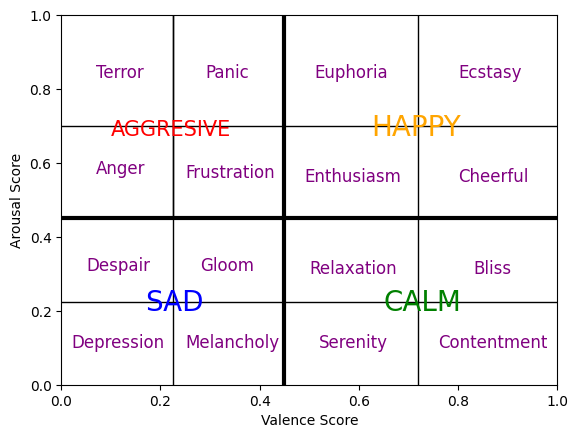

In [ ]:
fig, ax = plt.subplots()
  # Set x-axis range
plt.xlim((0,1))
    # Set y-axis range
plt.ylim((0,1))

plt.xlabel("Valence Score")
plt.ylabel("Arousal Score")


plt.plot([0.45,0.45],[0,1], linewidth=3, color='black' )
plt.plot([0,1],[0.45,0.45], linewidth=3, color='black' )
plt.plot([0.225,0.225],[0,0.45], linewidth=1, color='black' )
plt.plot([0,0.45],[0.225,0.225], linewidth=1, color='black' )
plt.plot([0.225,0.225],[0.45,1], linewidth=1, color='black' )
plt.plot([0,0.45],[0.7,0.7], linewidth=1, color='black' )
plt.plot([0.225,0.225],[0.45,1], linewidth=1, color='black' )
plt.plot([0.72,0.72],[0.45,1], linewidth=1, color='black' )
plt.plot([0.45,1],[0.7,0.7], linewidth=1, color='black' )
plt.plot([0.72,0.72],[0,0.45], linewidth=1, color='black' )
plt.plot([0.45,1],[0.225,0.225], linewidth=1, color='black' )

plt.text(0.625, 0.675, "HAPPY", color = "orange", fontsize = 20)
plt.text(0.51, 0.83, "Euphoria", color = "purple", fontsize = 12)
plt.text(0.8, 0.83, "Ecstasy", color = "purple", fontsize = 12)
plt.text(0.49, 0.55, "Enthusiasm", color = "purple", fontsize = 12)
plt.text(0.8, 0.55, "Cheerful", color = "purple", fontsize = 12)

plt.text(0.65, 0.2, "CALM", color = "green", fontsize = 20)
plt.text(0.5, 0.3, "Relaxation", color = "purple", fontsize = 12)
plt.text(0.83, 0.3, "Bliss", color = "purple", fontsize = 12)
plt.text(0.52, 0.1, "Serenity", color = "purple", fontsize = 12)
plt.text(0.76, 0.1, "Contentment", color = "purple", fontsize = 12)

plt.text(0.1, 0.675, "AGGRESIVE", color = "red", fontsize = 15)
plt.text(0.07, 0.83, "Terror", color = "purple", fontsize = 12)
plt.text(0.07, 0.57, "Anger", color = "purple", fontsize = 12)
plt.text(0.29, 0.83, "Panic", color = "purple", fontsize = 12)
plt.text(0.25, 0.56, "Frustration", color = "purple", fontsize = 12)

plt.text(0.17, 0.2, "SAD", color = "blue", fontsize = 20)
plt.text(0.05, 0.31, "Despair", color = "purple", fontsize = 12)
plt.text(0.28, 0.31, "Gloom", color = "purple", fontsize = 12)
plt.text(0.02, 0.1, "Depression", color = "purple", fontsize = 12)
plt.text(0.25, 0.1, "Melancholy", color = "purple", fontsize = 12)




Below is a function that allows one to load a model that exists in the google drive by specifying its name


In [ ]:
#Function to load a model, please provide the name i.e emotio1
Ausef = '/content/drive/MyDrive/YEAR 3 SEM 1/APS360/MODELS'
Jonas = '/content/drive/MyDrive/Colab Notebooks/APS360/MODELS'
def load_model(name, test = False):
    file_path = os.path.join(Ausef, name)
    net = EmotioNet(name = name)
    net = torch.load(file_path)
    if test:
      net.eval()
      print("Loaded model", name, "for testing")
    else:
      print("Loaded model", name, "for training/validation")
    return net

# 3. Hyperparameter Tuning
### This section consists of training our model using different hyperparameters to achieve optimal results in our metrics. 

We begin with increasing the number of epochs to 6. (balancing computation time and longevity, settled for 6) Before changing any other hyperparameters its best to get a sense of the models behaviour over a extended period of time so we are not just capturing an outlier with only 3 epochs. From there we can tune more depending on what we gather from the results. We begin with an initial learning rate of 0.03 and a batch size of 16. We likely will not change batch size as computation time dramatically increases past 16 (from small prior tests) and we want to focus on nuances of the data due to our high number of 16 classes. From some preliminary tests on a small number of epochs 16 also seems like the optimal value for batch size.

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

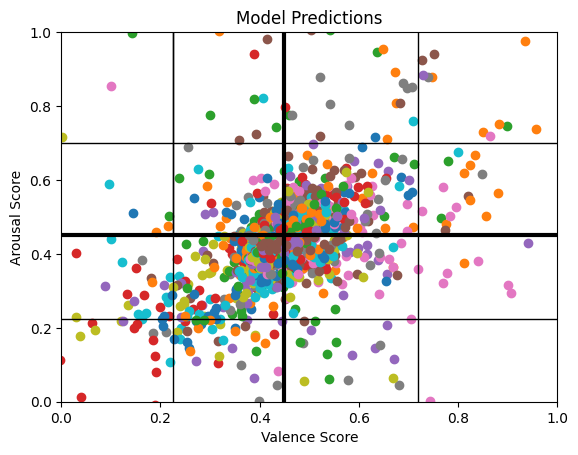

In [ ]:
emotio1 = EmotioNet("emotio1")

#start with 6 epochs to get a better sense of overall model behaviour before tuning any other hyperparameters
train_net(emotio1, train_loader, val_loader, num_epochs = 6)

### Above is a plot of our models predictions to get a sense of what its doing, we also observe fairly even distribution. Lets take a look at our metrics:

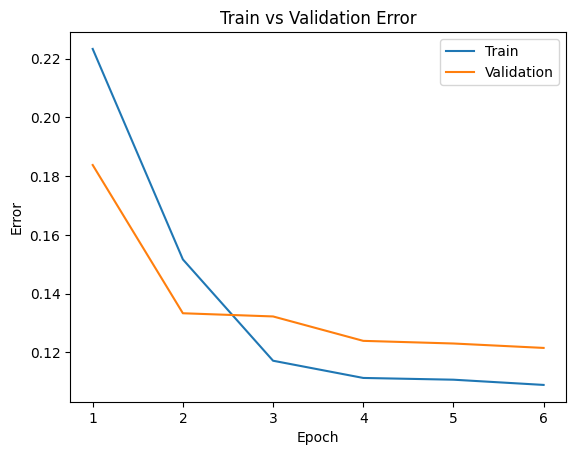

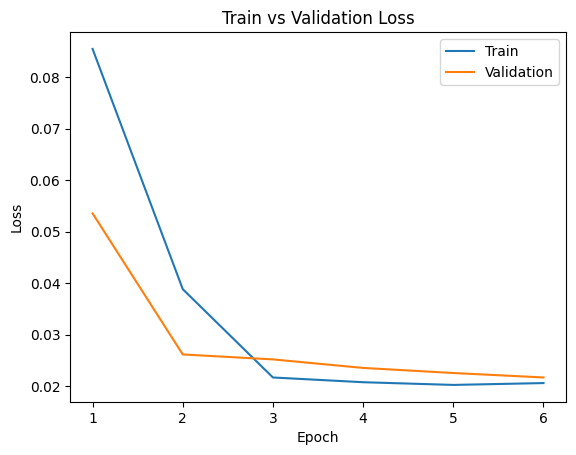

In [ ]:
path = get_model_name(name = emotio1.name, batch_size = 32, learning_rate = 0.03, epoch = 5)
plot_training_curve(path)

And lets see how close some of our guesses are to our ground truths to get a better picture of our model's accuracy

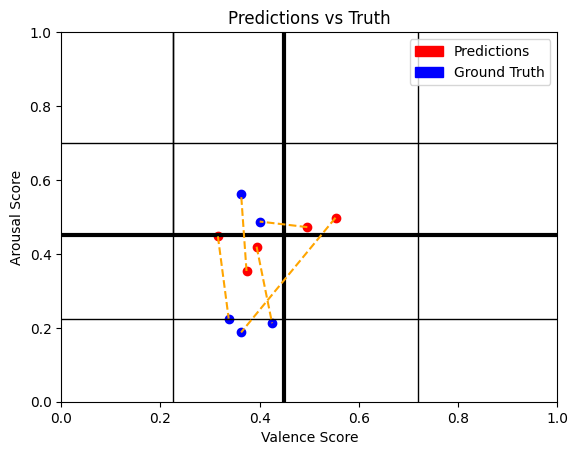

In [ ]:
plot_pred_vs_truth(emotio1)

As we can see from a few randomly selected samples, our model is fairly close to the ground truth. With all this in mind we can begin tuning our hyperparameters

## Evaluation 1 
It seems like both our loss and error begin to settle and stop decreasing if we were to continue past 6 epochs. We intend to fix this somehow while also training a model on a bigger number of epochs to get the best possible model we can, first we will slightly decrease the number of epochs to 5 and test a smaller learning rate on the model, to see if there is a more gradual but longer in terms of epoch length decrease of the metrics that we could exploit when we eventually go for a longer training period.

We decrease epochs to 5, learning rate to 0.001 and maintain our batch size.

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

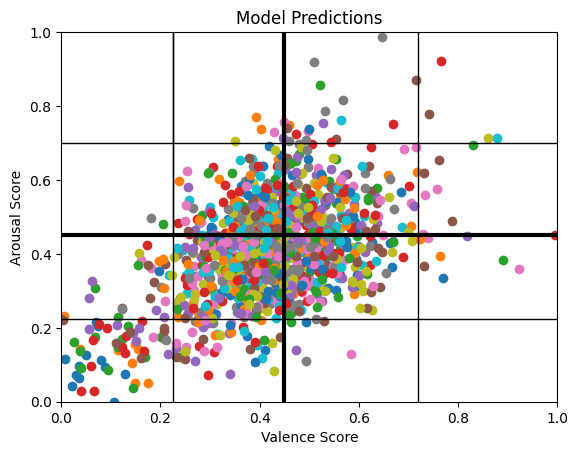

In [ ]:
emotio2 = EmotioNet("emotio2")
#learning rate  = 0.001, batch size = 16, num_epochs = 5
train_net(emotio2, train_loader, val_loader, learning_rate = 0.001, batch_size = 16, num_epochs = 5)

We notice a similar even spread of results, interestingly there are many predictions that correspond to a valence and arousal of < 0.2, which corresponds to "depressed". Lets look at our metrics:

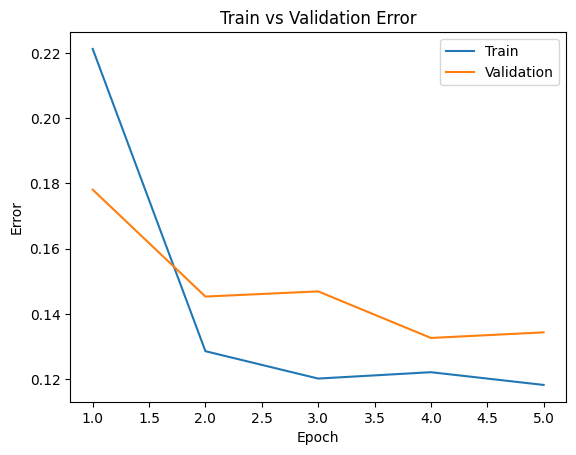

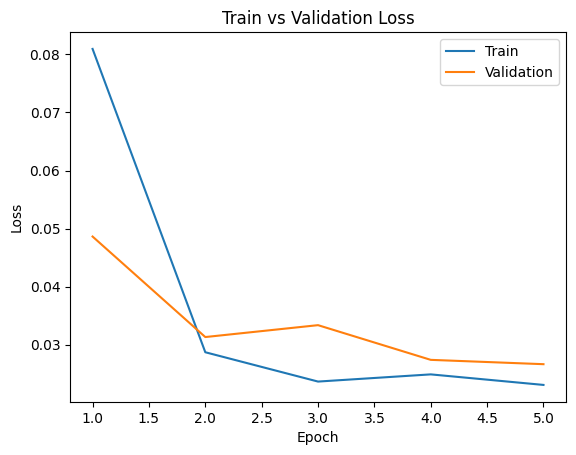

In [ ]:
path = get_model_name(name = emotio2.name, batch_size = 16, learning_rate = 0.001, epoch = 4)
plot_training_curve(path)

And a nice visualization of our predictions vs our ground truths to get a tangible example of how our model performs

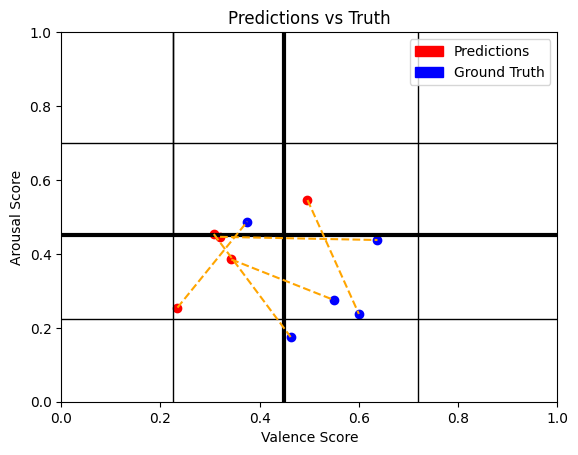

In [ ]:
plot_pred_vs_truth(emotio2)

# Evaluation 2:
Unsurpirsingly, with the much smaller learning rate and smaller number of epochs, we achieved slightly higher error and loss values, and we can see from the pred vs. ground truth that we are predicting slightly worse in the second model. We suspect that this lower learning rate could outperform the higher learning rate in emotio1 if trained for more epochs, but we do not have adequate computational power nor time to test that. Instead, we will find a solid middle ground (increase epochs as we are going for a strong model at this point with a slight bias towards smaller learning rate for reasons aforementioned)


We will now test a model with a learning rate of 0.001, over 11 epochs.

In [ ]:
emotio_model = EmotioNet("emotio_model")
#learning rate  = 0.01, batch size = 16, num_epochs = 11
train_net(emotio_model, train_loader, val_loader, batch_size = 16, learning_rate = 0.01, num_epochs = 11)

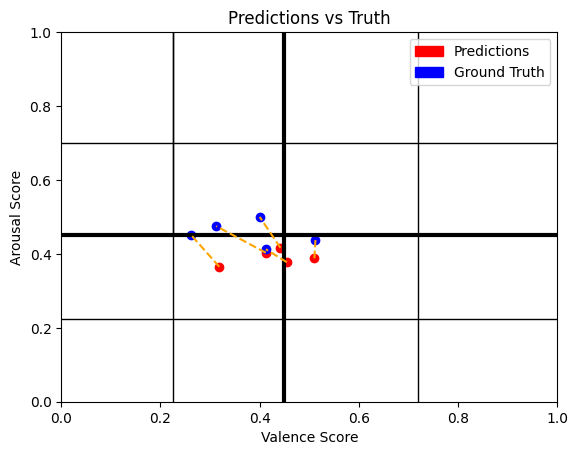

In [ ]:
plot_pred_vs_truth(emotio_model)

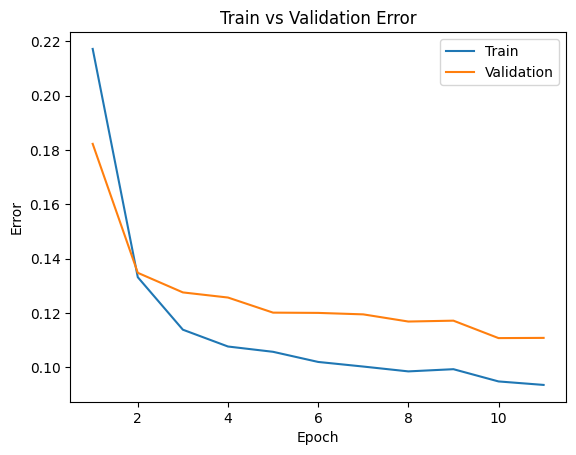

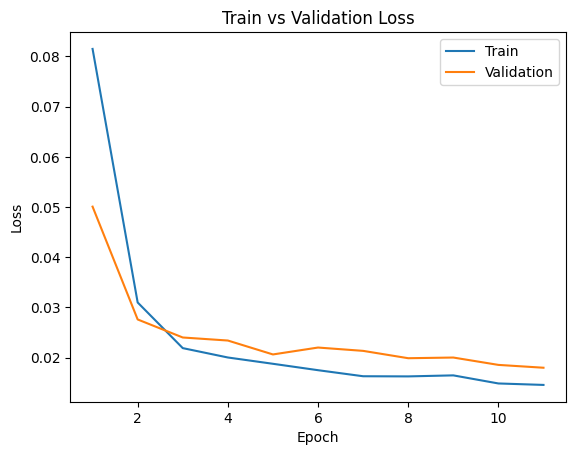

In [ ]:
path = get_model_name(name = emotio_model.name, batch_size = 16, learning_rate = 0.01, epoch = 10)
plot_training_curve(path)

In [ ]:
#accidentally deleted training outputs, load here
emotio_model = load_model("emotio_model")

Loaded model emotio_model for training/validation


# Evaluation 3
When comparing exact values of our 4 metrics we can clearly see that this model is the best so far. We are going to maintain the learning rate and were successful in inducing a nice downwards trend that is still active at 11 epochs, to which we will exploit by extending to 15 epochs, below.

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

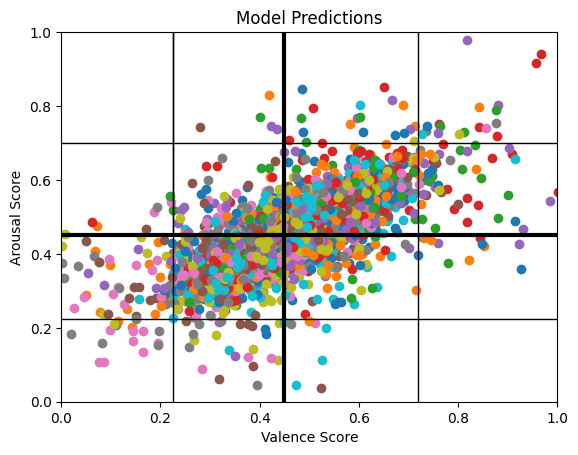

In [ ]:
emotio_model_ext = EmotioNet("emotio_model_ext")
#learning rate  = 0.01, batch size = 16, num_epochs = 15
train_net(emotio_model_ext, train_loader, val_loader, batch_size = 16, learning_rate = 0.01, num_epochs = 15)

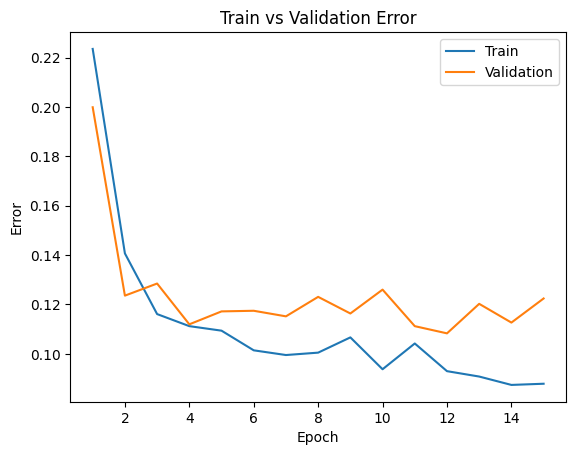

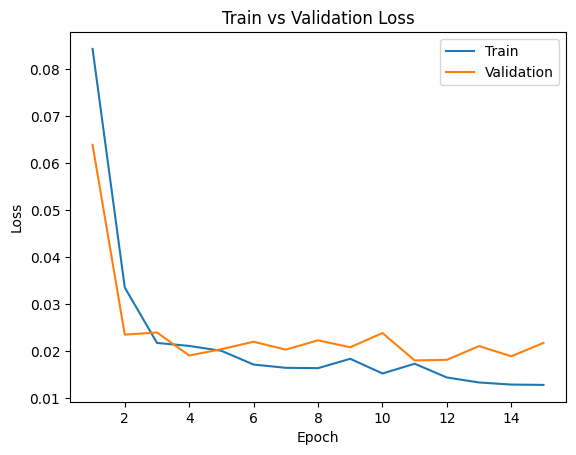

In [ ]:
path = get_model_name(name = emotio_model_ext.name, batch_size = 16, learning_rate = 0.01, epoch = 14)
plot_training_curve(path)

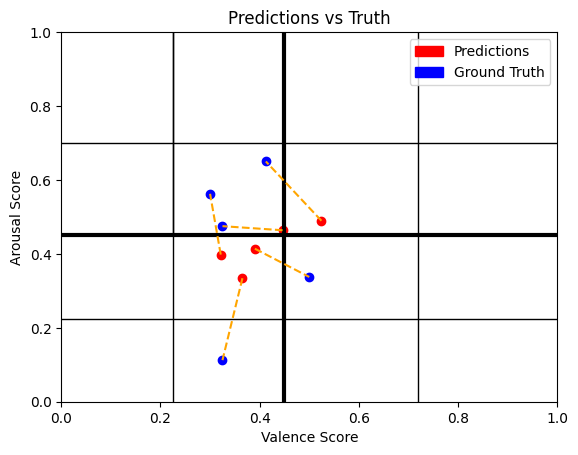

In [ ]:
plot_pred_vs_truth(emotio_model_ext)

# Evaluation 4

Not as good as we hoped, but it is clear what we should do:

First, oscilation is too high, we will decrease the learning rate.
Second, validation error and loss are too high, lets add a weight decay (of 1e-5) and swap to the ADAM optimizer
Third, We will lower our number of epochs. Our plan didnt work out and our downwards trend did not extend to 15 epochs. We will return to the industry standard 11 for training deep networks.

In [ ]:
final_model = EmotioNet("final_model")
#learning rate  = 0.001, batch size = 16, num_epochs = 11
train_net(final_model, train_loader, val_loader, batch_size = 16, learning_rate = 0.001, num_epochs = 11)

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

KeyboardInterrupt: ignored

### Stopped this training for the sake of time. The metrics dont look good and started to see some oscilation. (tried with a higher weight decay of 1e-4 and got even worse results) We return to SGD with our original plan of a lower learning rate, epoch # and a small weight decay

# Next one:

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

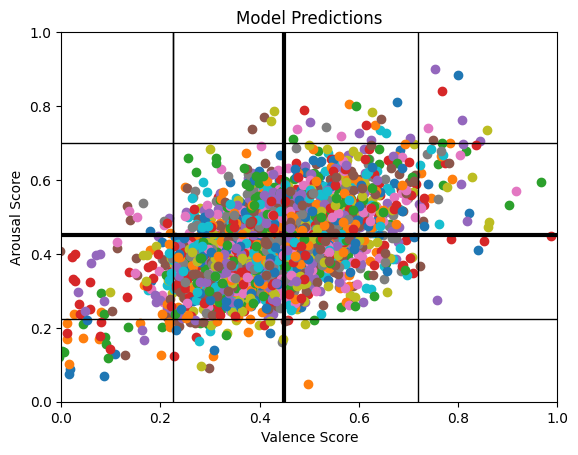

In [ ]:
emotio_final = EmotioNet("emotio_final")
train_net(emotio_final, train_loader, val_loader, batch_size = 16, learning_rate = 0.001, num_epochs = 11)

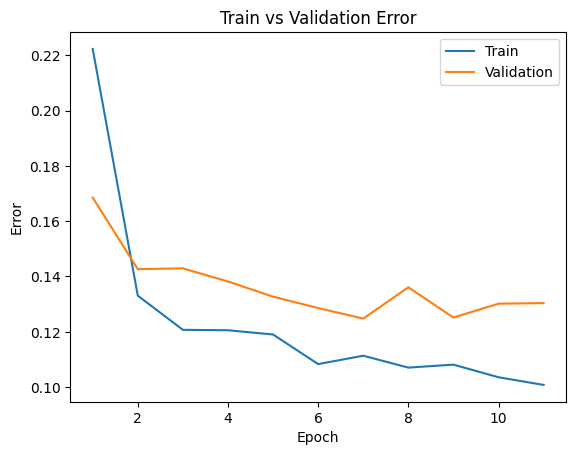

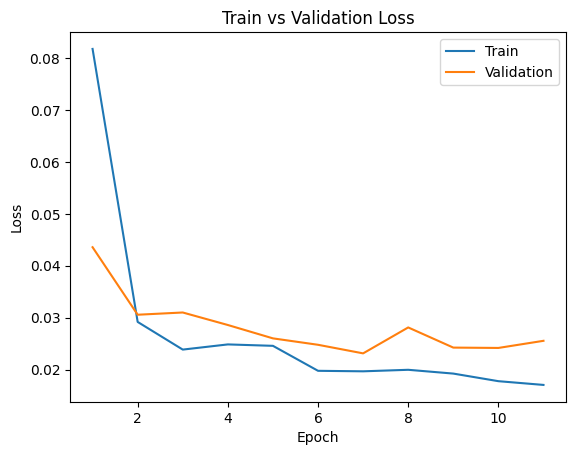

In [ ]:
path = get_model_name(name = emotio_final.name, batch_size = 16, learning_rate = 0.001, epoch = 10)
plot_training_curve(path)

### Lets try an even lower learning rate, but not make the same mistake of increasing epochs.

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

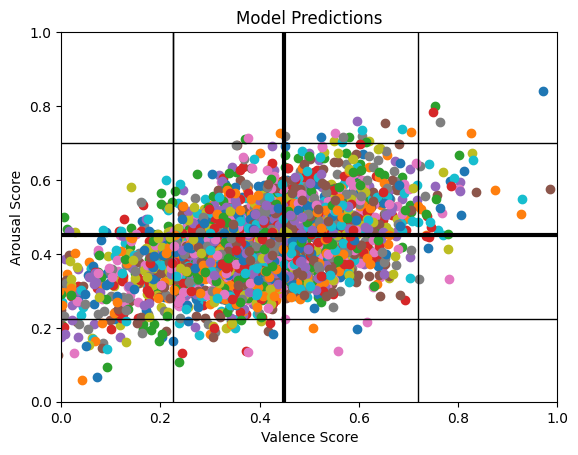

In [ ]:
emotio_final_2 = EmotioNet("emotio_final_2")
train_net(emotio_final_2, train_loader, val_loader, batch_size = 16, learning_rate = 0.0001, num_epochs = 11)

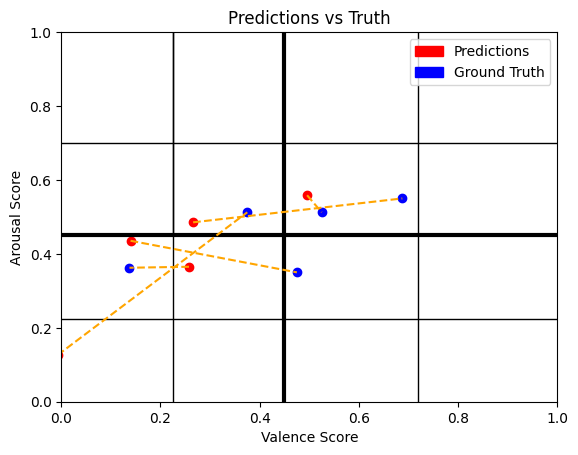

In [ ]:
plot_pred_vs_truth(emotio_final_2)

In [ ]:
emotio_final_2 = load_model("emotio_final_2")

Loaded model emotio_final_2 for training/validation


In [ ]:
path = get_model_name(name = emotio_final_2.name, batch_size = 16, learning_rate = 0.0001, epoch = 10)
plot_training_curve(path)

# Evaluation 5:
Validation does a better job at staying with our training metric, but they are both slightly higher, lets try a batch size of 32, tweak our learning rate.

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([32, 2

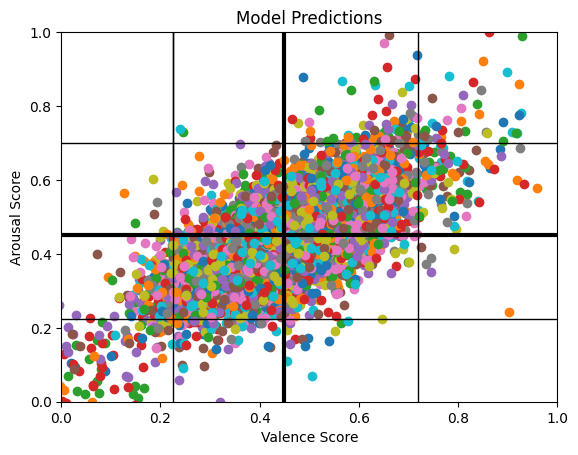

In [ ]:
emotioNet = EmotioNet("emotioNet")
train_net(emotioNet, train_loader, val_loader, batch_size = 32, learning_rate = 0.001, num_epochs = 10)

# Evaluation 6
Validation MAE is still not as low as it could be, slightly tweak learning rate, num epochs and rate of weight decay.

Model Using Cuda
Batch 0: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 1: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 2: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 3: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 4: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 5: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 6: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 7: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 8: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 9: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 10: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2])
Batch 11: Inputs shape torch.Size([3, 13, 3800]), Labels shape torch.Size([16, 2

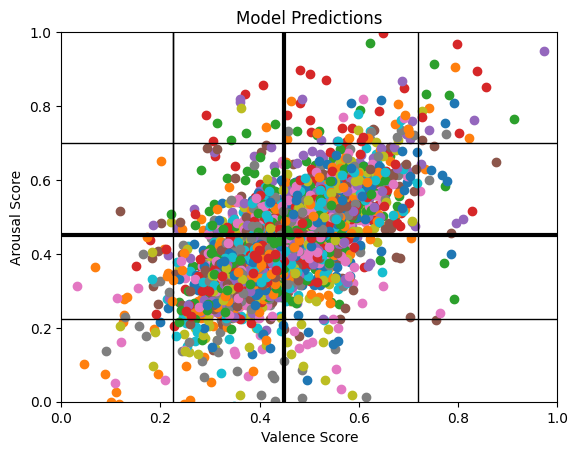

In [ ]:
emotio4 = EmotioNet("emotio4")
train_net(emotio4, train_loader, val_loader, learning_rate = 0.008, batch_size = 16, num_epochs = 14)

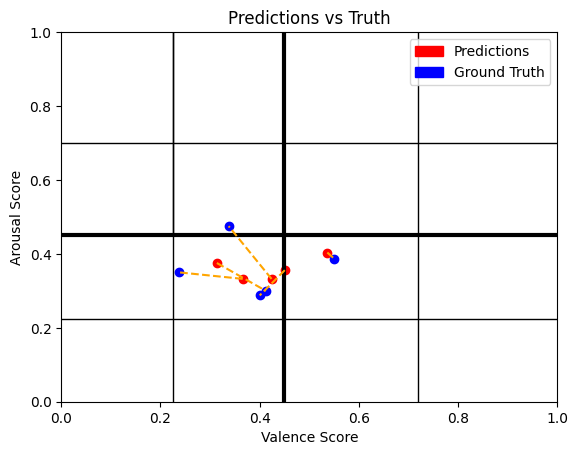

In [ ]:
plot_pred_vs_truth(emotio4)

Loaded model emotio4 for training/validation
3584


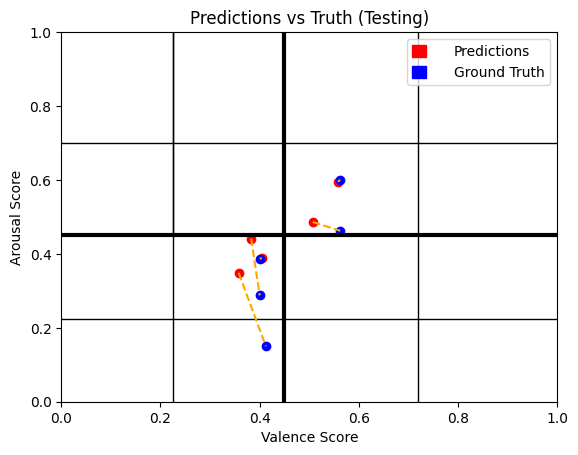

In [ ]:
mdl = load_model("emotio4")
plot_pred_vs_truth(mdl, num_points = 5)

3584


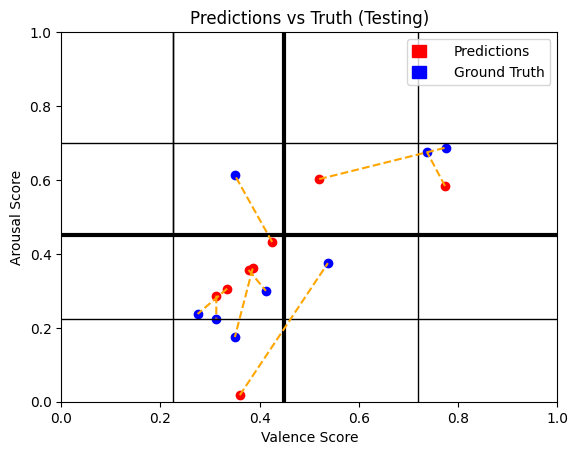

In [ ]:
plot_pred_vs_truth(mdl, num_points = 8)

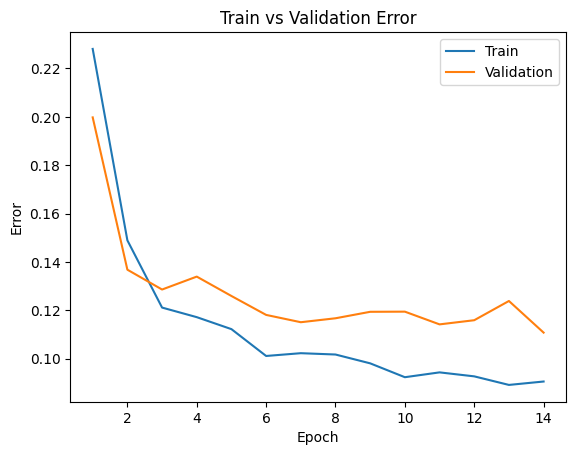

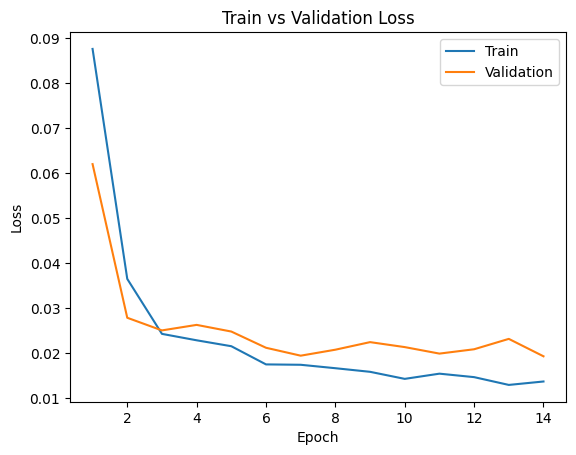

In [ ]:
path = get_model_name(name = emotio4.name, batch_size = 16, learning_rate = 0.008, epoch = 13)
plot_training_curve(path)

# Evaluation 6 - Final
Overall, we select emotio_model as our best model. emotio4 is our plan B model. The reason for these selections is that while emotio_model perfomed the best overall, we used better training techniques such as weight decay in emotio4 so it is reasonable to assume that even though it may have performed slightly worse than emotio_model, it has learned more robust features and is not depending on unusually large weights/biases. For this reason, we will move forward with emotio_model but if it is not perfoming well with the test data, we are confident in emotio4 as well, evaluation on these models and our choice is done in the next section.

# 4. Model Testing & Testing Evaluation

Define a function that evaluates our model on test data

In [ ]:
def test_evaluate(net, loader, criterion, use_cuda=True):
    total_loss = 0.0
    total_mae = 0.0
    total_epoch = 0

    net.outputs_t = []
    net.labels_t = []

    # Move the model to the appropriate device
    if use_cuda and torch.cuda.is_available():
        net = net.to('cuda')
        criterion = criterion.to('cuda')
    else:
        net = net.to('cpu')

    for i, data in enumerate(loader, 0):
        inputs, labels = data

        # Move the data to the same device as the model
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.to('cuda')
            labels = labels.to('cuda')
        else:
            inputs = inputs.to('cpu')
            labels = labels.to('cpu')

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Save outputs for plotting
        net.outputs_t.append(outputs.detach().cpu())
        net.labels_t.append(labels.cpu())

        total_loss += loss.item()
        total_mae += torch.mean(torch.abs(outputs - labels)).item()
        total_epoch += len(labels)

    return float(total_loss) / (i + 1), float(total_mae) / (i + 1)


We begin with loading our chosen model, in testing mode (model.eval() drops regularization tactics)

In [ ]:
#NOTE: model to test data on is loaded with following code, run it to load best model
#into test_model object.
test_model = load_model("emotio_model", test = True)

Loaded model emotio_model for testing


In [ ]:
#PLAN B LOAD
emotio4_model = load_model("emotio4", test = True)

Loaded model emotio4 for testing


Evaluate our model on test data

In [ ]:
test_loss_test_model, test_mae_test_model = test_evaluate(test_model, test_loader, nn.MSELoss())

132


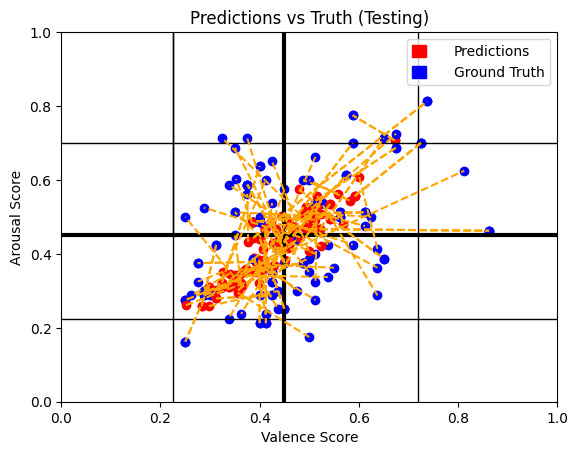

In [ ]:
plot_pred_vs_truth(test_model, t = True,  num_points = 132)

In [ ]:
test_model_df = create_mood_dataframe(test_model)
test_model_df

,Arousal_Pred,Valence_Pred,Mood_Pred,Sub_Mood_Pred,Arousal_Truth,Valence_Truth,Mood_Truth,Sub_Mood_Truth
0,0.573806,0.578735,Happy,Enthusiasm,0.63750,0.53750,Happy,Enthusiasm
1,0.439072,0.437674,Sad,Melancholy,0.37500,0.71250,Aggressive,Frustration
2,0.318086,0.370813,Sad,Melancholy,0.55625,0.51125,Happy,Enthusiasm
3,0.367529,0.352982,Sad,Melancholy,0.38750,0.38750,Sad,Melancholy
4,0.432923,0.398391,Sad,Melancholy,0.42500,0.27500,Sad,Melancholy
...,...,...,...,...,...,...,...,...
127,0.441970,0.406840,Sad,Melancholy,0.66250,0.46250,Calm,Serenity
128,0.349989,0.328948,Sad,Melancholy,0.25000,0.27500,Sad,Gloom
129,0.312831,0.302702,Sad,Melancholy,0.41250,0.60000,Aggressive,Frustration
130,0.466837,0.448376,Sad,Melancholy,0.52500,0.53750,Happy,Enthusiasm


In [ ]:
test_loss_emotio4_model, test_mae_emotio4_model = test_evaluate(emotio4_model, test_loader, nn.MSELoss())

132


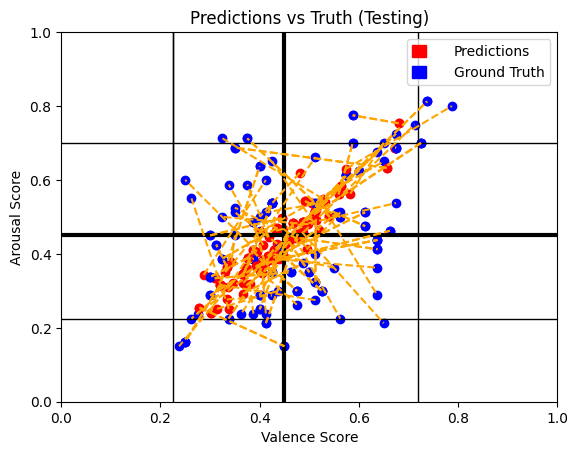

In [ ]:
plot_pred_vs_truth(emotio4_model, t = True,  num_points = 132)

In [ ]:
print(f"Test loss for Emotio4: {test_loss_emotio4_model}\nTest MAE for Emotio4: {test_mae_emotio4_model}")

Test loss for Emotio4: 0.019189462583098147
Test MAE for Emotio4: 0.1089017962416013


In [ ]:
emotio4_df = create_mood_dataframe(emotio4_model)
emotio4_df

,Arousal_Pred,Valence_Pred,Mood_Pred,Sub_Mood_Pred,Arousal_Truth,Valence_Truth,Mood_Truth,Sub_Mood_Truth
0,-0.056865,-0.054254,Sad,Depression,0.4125,0.6500,Aggressive,Frustration
1,-0.043568,-0.040147,Sad,Depression,0.4250,0.2250,Sad,Despair
2,-0.027086,-0.193123,Sad,Depression,0.6125,0.7250,Happy,Enthusiasm
3,-0.010499,-0.183416,Sad,Depression,0.6125,0.3375,Calm,Serenity
4,-0.125483,-0.233325,Sad,Depression,0.5375,0.4250,Calm,Serenity
...,...,...,...,...,...,...,...,...
3579,0.602770,0.669344,Happy,Enthusiasm,0.7000,0.8250,Happy,Cheerfulness
3580,0.650534,0.529355,Happy,Enthusiasm,0.8125,0.2875,Calm,Relaxation
3581,0.357106,0.310332,Sad,Melancholy,0.1875,0.4000,Sad,Gloom
3582,0.395394,0.388471,Sad,Melancholy,0.4500,0.3375,Sad,Melancholy


In [ ]:
"""This was the code used to determine the range of values for the MFCCs, Spectral Contrast, and Chroma features."""

#Initialize the min and max values as None for comparison, took 19 min to compute!
# Output:
          #MFCCs range: -756.3789672851562 to 308.3226318359375
          #Spectral Contrast range: 0.024821940717373536 to 80.62911344477574
          #Chroma range: 0.0 to 1.0

mfcc_max, mfcc_min = None, None
spc_max, spc_min = None, None
chr_max, chr_min = None, None
def get_max_min_vals():
  for i in training_indices:
      song_id = get_song_id(i)
      path = f'{file_path}/DEAM_audio/MEMD_audio/{song_id}.mp3'
      y, sr = librosa.load(path, sr=44100)

      # Compute the features
      mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
      spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
      chroma = librosa.feature.chroma_stft(y=y, sr=sr)

      # Update the max and min for MFCCs
      mfcc_max = np.max(mfccs) if mfcc_max is None else max(mfcc_max, np.max(mfccs))
      mfcc_min = np.min(mfccs) if mfcc_min is None else min(mfcc_min, np.min(mfccs))

      # Update the max and min for Spectral Contrast
      spc_max = np.max(spectral_contrast) if spc_max is None else max(spc_max, np.max(spectral_contrast))
      spc_min = np.min(spectral_contrast) if spc_min is None else min(spc_min, np.min(spectral_contrast))

      # Update the max and min for Chroma
      chr_max = np.max(chroma) if chr_max is None else max(chr_max, np.max(chroma))
      chr_min = np.min(chroma) if chr_min is None else min(chr_min, np.min(chroma))

  print(f"MFCCs range: {mfcc_min} to {mfcc_max}")
  print(f"Spectral Contrast range: {spc_min} to {spc_max}")
  print(f"Chroma range: {chr_min} to {chr_max}")

# 4. Baseline Model

In this section we loaded the data and extracted features using SVR

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier


In [ ]:
# Loading music data
music_data = pd.read_csv(f'{file_path}/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
music_data = music_data.head(100)

#X = music_data.drop(columns=['valence', 'arousal'])

song_id = music_data['song_id']
y_valence = music_data[' valence_mean']  # Numeric valence scores
y_arousal = music_data[' arousal_mean']  # Numeric arousal scores

X = []
for item in song_id:
  #print(item)
  features = extract_features(f'{file_path}/DEAM_audio/MEMD_audio/{item}.mp3')
  X.append(features)


In [ ]:
svr_poly(X,y_valence, y_arousal, "rbf","poly",10,10,3,3)

(8, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 1.0824894781229557
Valence Predictions - R-squared (R2) Score: -47.11064347213142
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.7774945941173763
Arousal Predictions - R-squared (R2) Score: -13.510159951978574


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

In [ ]:
svr_poly(X,y_valence, y_arousal, "rbf","poly",10,10,3,3)

(80, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 1.0182973729523623
Valence Predictions - R-squared (R2) Score: 0.24708063322177043
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.3566751904787993
Arousal Predictions - R-squared (R2) Score: 0.19109479773585936


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

In [ ]:
def extract_features(file_path):
  y, sr = librosa.load(file_path, sr=44100)
  # Extract MFCCs
  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
  mfccs = mfccs[:, :3879]

  mfccs = mfccs.flatten()

  # Extract Spectral Contrast
  #spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512, fmin=200, n_bands=6)
  # Extract Chroma
  #chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512, n_chroma=12)
  # Extract Tempogram

  return mfccs


In [ ]:
# Loading music data
music_data = pd.read_csv(f'{file_path}/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
music_data = music_data.head(300)

#X = music_data.drop(columns=['valence', 'arousal'])

song_id = music_data['song_id']
y_valence = music_data[' valence_mean']  # Numeric valence scores
y_arousal = music_data[' arousal_mean']  # Numeric arousal scores

X = []
for item in song_id:
  #print(item)
  features = extract_features(f'{file_path}/DEAM_audio/MEMD_audio/{item}.mp3')
  X.append(features)


In [ ]:


def svr(X,y_valence, y_arousal, num_epoch, kernel_type_valence, kernel_type_arousal, c_valence, c_arousal):

  # Split the data into training and testing sets
  X = pd.DataFrame(X)
  X_train, X_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(X, y_valence, y_arousal, test_size=0.2, random_state=42)

  # Choose SVR models for valence and arousal
  svr_valence = SVR(kernel=f'{kernel_type_valence}', C=c_valence)
  svr_arousal = SVR(kernel=f'{kernel_type_arousal}', C=c_arousal)


  # Train the SVR models

  X_train = pd.DataFrame(X_train)
  X_train["val"] = y_valence_train
  X_train["Ar"] = y_arousal_train

  #print(X_train.shape)
  # Filter out rows with missing values (NaN) in any column
  train_data = X_train.dropna()
  print(train_data.shape)
  # Separate the filtered data back into features and labels
  X_train = train_data.drop(columns=["val","Ar"])
  y_valence_train= train_data["val"].values.tolist()
  y_arousal_train=train_data["Ar"].values.tolist()

  svr_valence.fit(X_train, y_valence_train)
  svr_arousal.fit(X_train, y_arousal_train)

  X_test=pd.DataFrame(X_test)
  X_test["val"] = y_valence_test
  X_test["Ar"] = y_arousal_test
  test_data = X_test.dropna()
  X_test = test_data.drop(columns=["val","Ar"])
  y_valence_test= test_data["val"].values.tolist()
  y_arousal_test=test_data["Ar"].values.tolist()

  # Make predictions on the test data
  y_valence_pred = svr_valence.predict(X_test.astype(str) )
  y_arousal_pred = svr_arousal.predict(X_test.astype(str) )


  # Evaluate the models
  mse_valence = mean_squared_error(y_valence_test, y_valence_pred)
  r2_valence = r2_score(y_valence_test, y_valence_pred)

  mse_arousal = mean_squared_error(y_arousal_test, y_arousal_pred)
  r2_arousal = r2_score(y_arousal_test, y_arousal_pred)

  print(f"with {kernel_type_valence} type kernel:")
  print("Valence Predictions - Mean Squared Error:", mse_valence)
  print("Valence Predictions - R-squared (R2) Score:", r2_valence)
  VMSE.append(mse_valence)
  VR2.append(r2_valence)

  print(f"with {kernel_type_arousal} type kernel:")
  print("Arousal Predictions - Mean Squared Error:", mse_arousal)
  print("Arousal Predictions - R-squared (R2) Score:", r2_arousal)
  AMSE.append(mse_arousal)
  AR2.append(r2_arousal)
  return VMSE,VR2,AMSE,AR2
num_epoch = 1
VMSE, VR2,AMSE,AR2 = svr(X,y_valence, y_arousal, num_epoch, "linear","linear",1.0,1.0)




(238, 50429)
with linear type kernel:
Valence Predictions - Mean Squared Error: 0.8584497938544186
Valence Predictions - R-squared (R2) Score: 0.5266170896127689
with linear type kernel:
Arousal Predictions - Mean Squared Error: 1.6009887204072497
Arousal Predictions - R-squared (R2) Score: 0.09952297780293351


In [ ]:
svr(X,y_valence, y_arousal, num_epoch, "rbf","rbf",1.0,1.0)


(238, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.7461232083066381
Valence Predictions - R-squared (R2) Score: 0.5885583776894088
with rbf type kernel:
Arousal Predictions - Mean Squared Error: 1.3923590136057578
Arousal Predictions - R-squared (R2) Score: 0.21686687581282482


([0.7461232083066381],
 [0.5885583776894088],
 [1.3923590136057578],
 [0.21686687581282482])

In [ ]:
svr(X,y_valence, y_arousal, num_epoch, "rbf","rbf",10,1.0)


(238, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.6489773833179759
Valence Predictions - R-squared (R2) Score: 0.6421283985506407
with rbf type kernel:
Arousal Predictions - Mean Squared Error: 1.3923590136057578
Arousal Predictions - R-squared (R2) Score: 0.21686687581282482


([0.6489773833179759],
 [0.6421283985506407],
 [1.3923590136057578],
 [0.21686687581282482])

the one below is the best code


In [ ]:
svr(X,y_valence, y_arousal, num_epoch, "rbf","rbf",10,10)


(238, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.6489773833179759
Valence Predictions - R-squared (R2) Score: 0.6421283985506407
with rbf type kernel:
Arousal Predictions - Mean Squared Error: 1.2769225482566735
Arousal Predictions - R-squared (R2) Score: 0.28179418182411053


([0.6489773833179759],
 [0.6421283985506407],
 [1.2769225482566735],
 [0.28179418182411053])

In [ ]:
svr(X,y_valence, y_arousal, num_epoch, "rbf","rbf",100,100)


(238, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.776368798220941
Valence Predictions - R-squared (R2) Score: 0.5718797722747286
with rbf type kernel:
Arousal Predictions - Mean Squared Error: 1.38014317971006
Arousal Predictions - R-squared (R2) Score: 0.22373767857978855


([0.776368798220941],
 [0.5718797722747286],
 [1.38014317971006],
 [0.22373767857978855])

Lets try using polynomial

In [ ]:

def svr_poly(X,y_valence, y_arousal, kernel_type_valence, kernel_type_arousal, c_valence, c_arousal,degree_valence,degree_arousal):


  # Split the data into training and testing sets
  X = pd.DataFrame(X)
  X_train, X_test, y_valence_train, y_valence_test, y_arousal_train, y_arousal_test = train_test_split(X, y_valence, y_arousal, test_size=0.2, random_state=42)

  # Choose SVR models for valence and arousal
  svr_valence = SVR(kernel=f'{kernel_type_valence}', degree = degree_valence,C=c_valence)
  svr_arousal = SVR(kernel=f'{kernel_type_arousal}', degree =degree_arousal, C=c_arousal)
  #hist_gradient_boosting_valence = HistGradientBoostingRegressor()
  #hist_gradient_boosting_arousal = HistGradientBoostingRegressor()


  # Train the SVR models

  X_train = pd.DataFrame(X_train)
  X_train["val"] = y_valence_train
  X_train["Ar"] = y_arousal_train

  #print(X_train.shape)
  # Filter out rows with missing values (NaN) in any column
  train_data = X_train.dropna()
  print(train_data.shape)
  # Separate the filtered data back into features and labels
  X_train = train_data.drop(columns=["val","Ar"])
  y_valence_train= train_data["val"].values.tolist()
  y_arousal_train=train_data["Ar"].values.tolist()

  svr_valence.fit(X_train, y_valence_train)
  svr_arousal.fit(X_train, y_arousal_train)
  #hist_gradient_boosting_valence.fit(X_train, y_valence_train)
  #hist_gradient_boosting_arousal.fit(X_train, y_arousal_train)


  X_test=pd.DataFrame(X_test)
  X_test["val"] = y_valence_test
  X_test["Ar"] = y_arousal_test
  test_data = X_test.dropna()
  X_test = test_data.drop(columns=["val","Ar"])
  y_valence_test= test_data["val"].values.tolist()
  y_arousal_test=test_data["Ar"].values.tolist()
  # Make predictions on the test data
  y_valence_pred = svr_valence.predict(X_test)
  y_arousal_pred = svr_arousal.predict(X_test)

  # Evaluate the models
  mse_valence = mean_squared_error(y_valence_test, y_valence_pred)
  r2_valence = r2_score(y_valence_test, y_valence_pred)

  mse_arousal = mean_squared_error(y_arousal_test, y_arousal_pred)
  r2_arousal = r2_score(y_arousal_test, y_arousal_pred)

  print(f"with {kernel_type_valence} type kernel:")
  print("Valence Predictions - Mean Squared Error:", mse_valence)
  print("Valence Predictions - R-squared (R2) Score:", r2_valence)


  print(f"with {kernel_type_arousal} type kernel:")
  print("Arousal Predictions - Mean Squared Error:", mse_arousal)
  print("Arousal Predictions - R-squared (R2) Score:", r2_arousal)

  return VMSE,VR2,AMSE,AR2
svr_poly(X,y_valence, y_arousal, "poly","poly",0.8,1.0,1,3)

(238, 50429)
with poly type kernel:
Valence Predictions - Mean Squared Error: 0.8187319127764995
Valence Predictions - R-squared (R2) Score: 0.5485190881614084
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.428401057344617
Arousal Predictions - R-squared (R2) Score: 0.19659500768148108


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

In [ ]:
svr_poly(X,y_valence, y_arousal, "poly","poly",10,10,2,3)

(238, 50429)
with poly type kernel:
Valence Predictions - Mean Squared Error: 0.7371641385817164
Valence Predictions - R-squared (R2) Score: 0.5934987603781893
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.3106213617414737
Arousal Predictions - R-squared (R2) Score: 0.26284026489042445


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

In [ ]:
svr_poly(X,y_valence, y_arousal, "poly","poly",10,10,3,4)

(238, 50429)
with poly type kernel:
Valence Predictions - Mean Squared Error: 0.7954134988743132
Valence Predictions - R-squared (R2) Score: 0.5613777768321437
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.375919421921864
Arousal Predictions - R-squared (R2) Score: 0.22611333356543328


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

In [ ]:
svr_poly(X,y_valence, y_arousal, "poly","poly",100,100,3,3)

(238, 50429)
with poly type kernel:
Valence Predictions - Mean Squared Error: 0.8704360412756935
Valence Predictions - R-squared (R2) Score: 0.520007402325842
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.3602877173501797
Arousal Predictions - R-squared (R2) Score: 0.2349053947493459


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

** **Clearly** our best set of scenario is for valence : rbf kernel with C value of 10
for arousal is:polynomial kernel with degree of 3 and C value of 10 **

In [ ]:
svr_poly(X,y_valence, y_arousal, "rbf","poly",10,10,3,3)

(238, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.6489773831808274
Valence Predictions - R-squared (R2) Score: 0.6421283986262698
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.3106213617414737
Arousal Predictions - R-squared (R2) Score: 0.26284026489042445


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

Now we will try with a larger dataset

In [ ]:
# Loading music data
music_data = pd.read_csv(f'{file_path}/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
music_data = music_data.head(1000)

#X = music_data.drop(columns=['valence', 'arousal'])

song_id = music_data['song_id']
y_valence = music_data[' valence_mean']  # Numeric valence scores
y_arousal = music_data[' arousal_mean']  # Numeric arousal scores

X = []
for item in song_id:
  #print(item)
  features = extract_features(f'{file_path}/DEAM_audio/MEMD_audio/{item}.mp3')
  X.append(features)


In [ ]:
svr_poly(X,y_valence, y_arousal, "rbf","poly",10,10,3,3)

(634, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.9864408268110012
Valence Predictions - R-squared (R2) Score: 0.45278343801252097
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.7410007146975457
Arousal Predictions - R-squared (R2) Score: 0.0017890644476870055


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

you can see as the set decresese the accuracy gets better

In [ ]:
# Loading music data
music_data = pd.read_csv(f'{file_path}/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
music_data = music_data.head(500)

#X = music_data.drop(columns=['valence', 'arousal'])

song_id = music_data['song_id']
y_valence = music_data[' valence_mean']  # Numeric valence scores
y_arousal = music_data[' arousal_mean']  # Numeric arousal scores

X = []
for item in song_id:
  #print(item)
  features = extract_features(f'{file_path}/DEAM_audio/MEMD_audio/{item}.mp3')
  X.append(features)


In [ ]:
svr_poly(X,y_valence, y_arousal, "rbf","poly",10,10,3,3)

(396, 50429)
with rbf type kernel:
Valence Predictions - Mean Squared Error: 0.8472124193840366
Valence Predictions - R-squared (R2) Score: 0.49241381763246816
with poly type kernel:
Arousal Predictions - Mean Squared Error: 1.197505192627821
Arousal Predictions - R-squared (R2) Score: 0.20360282399005536


([0.8584497938544186],
 [0.5266170896127689],
 [1.6009887204072497],
 [0.09952297780293351])

In [ ]:
# Loading music data
music_data = pd.read_csv(f'{file_path}/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
music_data = music_data.head(10)

#X = music_data.drop(columns=['valence', 'arousal'])

song_id = music_data['song_id']
y_valence = music_data[' valence_mean']  # Numeric valence scores
y_arousal = music_data[' arousal_mean']  # Numeric arousal scores

X = []
for item in song_id:
  #print(item)
  features = extract_features(f'{file_path}/DEAM_audio/MEMD_audio/{item}.mp3')
  X.append(features)


# 5. Evaluating Model on Unseen Test Data

In [ ]:
torch.manual_seed(1000)
new_data_indices = torch.randperm(len(new_data_df)).tolist()
new_data_testset = MusicEmotionDataset(new_data_indices, new_data = True)
new_data_testset_loader = DataLoader(new_data_testset, batch_size=4, shuffle=True)

In [ ]:
test_loss_emotio4_model, test_mae_emotio4_model = test_evaluate(emotio4_model, new_data_testset_loader, nn.MSELoss())

<ipython-input-140-b392a3f10fcb>:17: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(path, sr=44100)


76


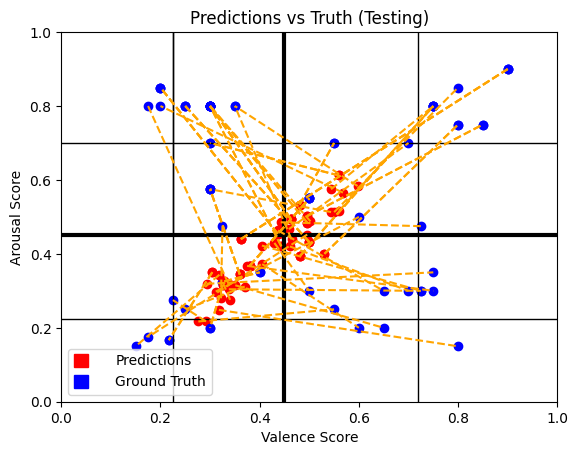

Test loss for Emotio4: 0.06357774324715137
Test MAE for Emotio4: 0.2141260481194446


In [ ]:
plot_pred_vs_truth(emotio4_model, t = True,  num_points = 70)
print(f"Test loss for Emotio4: {test_loss_emotio4_model}\nTest MAE for Emotio4: {test_mae_emotio4_model}")

In [ ]:
jennifer = "/content/drive/MyDrive/APS360"
chielo = "/content/drive/MyDrive/Colab Notebooks/APS360"
jonas = "/content/drive/MyDrive/Colab Notebooks/APS360"
ausef = "/content/drive/MyDrive/YEAR 3 SEM 1/APS360"
file_p = ausef

import gspread
import time
from oauth2client.client import GoogleCredentials
from IPython.display import Audio, display
from google.colab import auth
from google.auth import default
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

def are_cells_filled(sheet, row, arousal_col, valence_col):
    """Check if the specific cells are filled out."""
    arousal_value = sheet.cell(row, arousal_col).value
    valence_value = sheet.cell(row, valence_col).value
    return bool(arousal_value) and bool(valence_value)

def play_song(file_name):
    # Assuming the .mp3 files are stored in your Google Drive in a specific folder
    path_to_file = f"{file_p}/new samples cropped/{file_name}"
    display(Audio(path_to_file, autoplay=True))

sheet = gc.open('Ranking Music Sentiment').sheet1
name = input("pls enter your name and capitalise the first letter so i know ur columns: ")

# Processing each row in the Sheet
starting_row = input("Go on the doc and lmk the index of where you wanna start listening from (e.g. from beginning is 2)")
for i in 0:#range(int(starting_row), sheet.row_count + 1):
    file_name = sheet.cell(i, 2).value

    print(f"Playing the song with file name: {file_name}")
    play_song(file_name)

    arousal_col = sheet.find(f"{name} Arousal").col
    valence_col = sheet.find(f"{name} Valence").col

    # Block until the cells are filled
    while not are_cells_filled(sheet, i, arousal_col, valence_col):
        time.sleep(5)

    print("Next one")


MessageError: Error: credential propagation was unsuccessful

In [ ]:
emotio1.eval()

predictions = []
actual_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move data to GPU if available and model was trained on GPU
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # Make predictions
        outputs = emotio1(inputs)
        predictions.append(outputs)

        # If you have actual labels, store them for evaluation
        actual_labels.append(labels)

valence_pred, arousal_pred = zip(*predictions)
valence_true, arousal_true = zip(*truth_labels)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(valence_pred, arousal_pred, c='blue', label='Predictions', alpha=0.5)
plt.scatter(valence_true, arousal_true, c='red', label='True Labels', alpha=0.5)

# Labeling the plot
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.title('Predictions vs True Labels')
plt.legend()
plt.grid(True)
plt.show()


Some visualization of our testing follows...

In [ ]:
emem = load_model("emotio4")

Loaded model emotio4 for training/validation


In [ ]:
emotio4_df = create_mood_dataframe(emem)

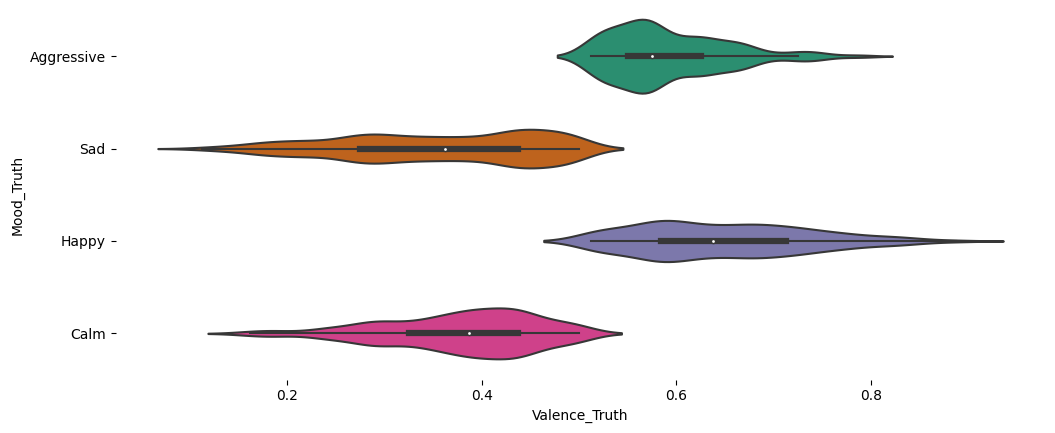

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(emotio4_df['Mood_Truth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(emotio4_df, x='Valence_Truth' , y='Mood_Truth', inner='box', palette='Dark2')
#if u want to plot other things like arousal values please change x = "" to the corresponding label in the dataframe,
#for example if i want model predictions of arousal I would put "Arousal_Pred"
sns.despine(top=True, right=True, bottom=True, left=True)

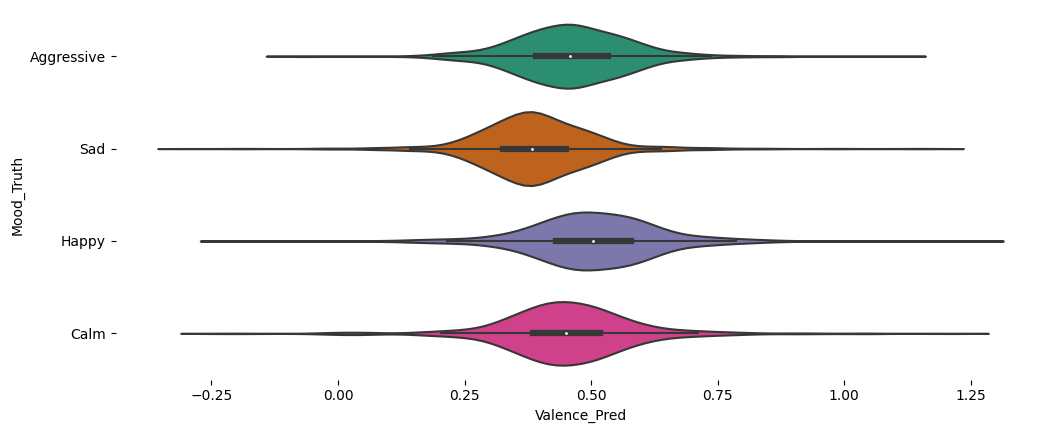

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(emotio4_df['Mood_Truth'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(emotio4_df, x='Valence_Pred' , y='Mood_Truth', inner='box', palette='Dark2')
#if u want to plot other things like arousal values please change x = "" to the corresponding label in the dataframe,
#for example if i want model predictions of arousal I would put "Arousal_Pred"
sns.despine(top=True, right=True, bottom=True, left=True)

Faceted distributions across our 4 main emotion classes for the value indicated on the x axis.

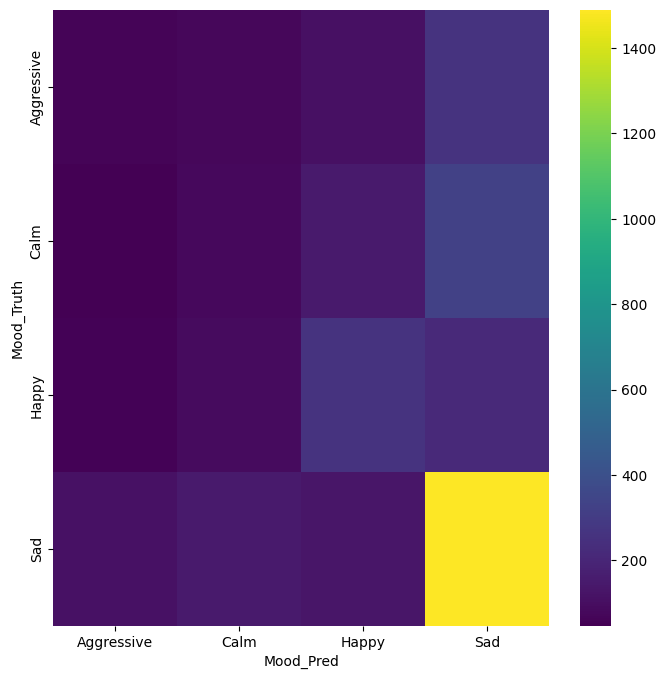

In [ ]:
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Mood_Truth'].value_counts()
    for x_label, grp in emotio4_df.groupby('Mood_Pred')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Mood_Pred')
_ = plt.ylabel('Mood_Truth')

Heatmap/confusion matrix for our emotio4 on testing data.

In [ ]:
emotio4_df.head()

,Arousal_Pred,Valence_Pred,Mood_Pred,Sub_Mood_Pred,Arousal_Truth,Valence_Truth,Mood_Truth,Sub_Mood_Truth
0,-0.056865,-0.054254,Sad,Depression,0.4125,0.6500,Aggressive,Frustration
1,-0.043568,-0.040147,Sad,Depression,0.4250,0.2250,Sad,Despair
2,-0.027086,-0.193123,Sad,Depression,0.6125,0.7250,Happy,Enthusiasm
3,-0.010499,-0.183416,Sad,Depression,0.6125,0.3375,Calm,Serenity
4,-0.125483,-0.233325,Sad,Depression,0.5375,0.4250,Calm,Serenity


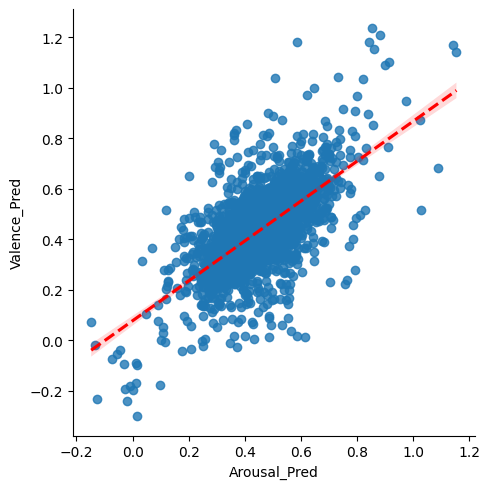

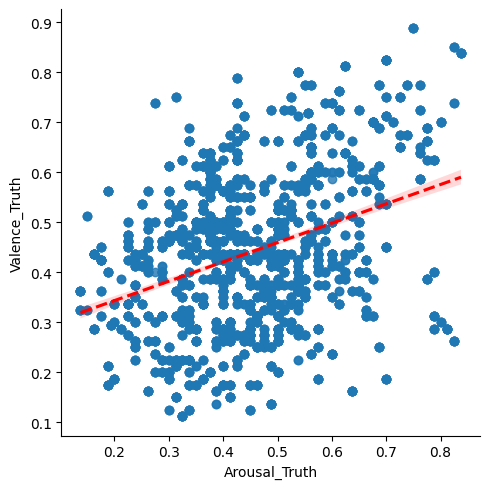

In [ ]:
sns.lmplot(data=emotio4_df, x='Arousal_Pred', y='Valence_Pred', fit_reg=True, line_kws={'color': 'red', 'linestyle': '--'})
sns.lmplot(data=emotio4_df, x='Arousal_Truth', y='Valence_Truth', fit_reg=True, line_kws={'color': 'red', 'linestyle': '--'})

Categorical Distrubtion of Guesses

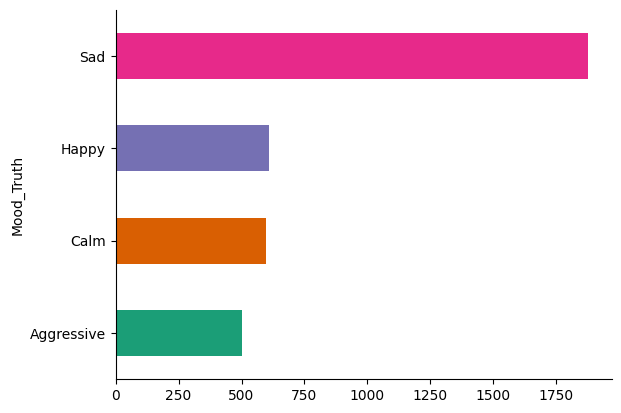

In [ ]:
#change mood_truth to whatever u would like to visualize
emotio4_df.groupby('Mood_Truth').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Small Demo Stuff - Ausef

In [ ]:
def extract_features_demo(song_id):
  # Parameter: path to .mp3 file
  # Returns list with features.

  path = f'/content/drive/MyDrive/YEAR 3 SEM 1/APS360/demosamples/{song_id}.mp3'

  try:
    y, sr = librosa.load(path, sr=44100)
  except:
    y, sr = librosa.load(f'{path}.mp3', sr=44100)

  mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
  spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, n_fft=2048, hop_length=512, fmin=200, n_bands=7)
  chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=2048, hop_length=512, n_chroma=12)
  all_features = [mfccs, spectral_contrast, chroma]

  all_features = [feature[:, :3800] for feature in all_features] # Curtailed dataset
  tensor_features = [torch.tensor(feature, dtype=torch.float32) for feature in all_features] # Tensorization

  # Normalisation and Padding of tensors
  normalized_mfccs = normalize_feature(tensor_features[0], MFCC_MIN, MFCC_MAX)
  normalized_spectral_contrast = normalize_feature(tensor_features[1], SPEC_CONTRAST_MIN, SPEC_CONTRAST_MAX)
  normalized_spectral_contrast = F.pad(normalized_spectral_contrast, (0, 0, 2, 3))
  normalized_chroma = normalize_feature(tensor_features[2], CHROMA_MIN, CHROMA_MAX)
  normalized_chroma = F.pad(normalized_chroma, (0, 0, 0, 1))

  # Feature Stacking
  normalized_stacked_features = torch.stack([normalized_mfccs, normalized_spectral_contrast, normalized_chroma], dim=0)

  # return normalized_features #, all_features
  return normalized_stacked_features #,all_features (for vizualisation)

In [ ]:
demo_model = load_model('emotio4', test = True).to("cpu")

Loaded model emotio4 for testing


First song: "Lovely" by Billie Eilish and Khalid

In [ ]:
input_lovely = extract_features_demo("Billie Eilish - lovely (Lyrics) ft. Khalid-[AudioTrimmer.com]")
out = demo_model(torch.reshape(input_lovely, (1, 3, 13, 3800)))
out = out.detach().numpy()

In [ ]:
categorize_mood(out[0][0],out[0][1])

('Sad', 'Melancholy')

Second song: "Perfect Night" by LE SSERAFIM

In [ ]:
input_PN = extract_features_demo("LE SSERAFIM (르세라핌) 'Perfect Night' OFFICIAL MV with OVERWATCH 2-[AudioTrimmer.com]")
out = demo_model(torch.reshape(input_PN, (1, 3, 13, 3800)))
out = out.detach().numpy()

In [ ]:
categorize_mood(out[0][0],out[0][1])

('Happy', 'Enthusiasm')